In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.25)
%matplotlib inline

## Section 1: Metadata

In [2]:
## Load survey data.
metadata = read_csv(os.path.join('data','metadata.csv'))
metadata = metadata.query('Session==1').reset_index(drop=True)

#### 1.1 Comprehension Loops

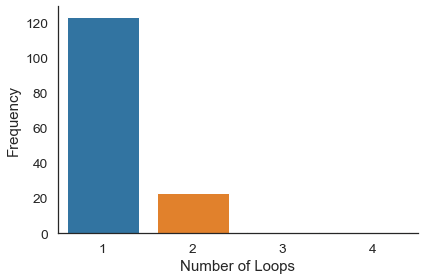

In [3]:
## Initialize rejection DataFrame.
reject = metadata[['Subject','Comp-Loops']].copy()

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot loops.
sns.countplot(reject['Comp-Loops'], ax=ax)
ax.set(xlabel='Number of Loops', ylabel='Frequency')

sns.despine()
plt.tight_layout()

## Section 2: Surveys

In [4]:
## Load survey data.
surveys = read_csv(os.path.join('data','surveys.csv'))
surveys = surveys.query('Session==1').reset_index(drop=True)

#### 2.1 Infrequency Items

Following Huang et al. (2015) and Ophir et al. (2019), we included 3 infrequency items in our surveys (1 per survey). These are items with only  one  correct  or  highly  probable  answer. Previous research suggests that a zero-tolerance scoring of infrequency items is too severe ([Kim et al., 2018](http://dx.doi.org/10.3758/s13428-017-0964-9)), thus we will not reject based on a single improbable answer. 

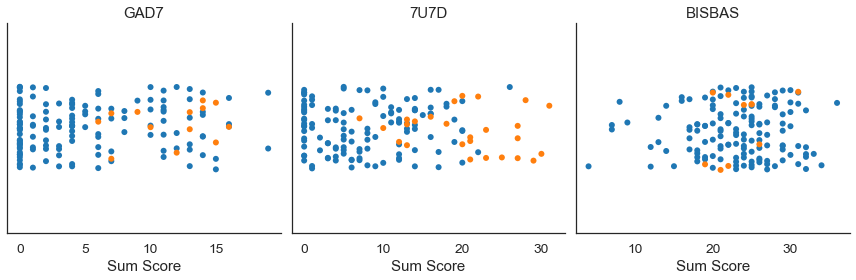

In [5]:
## Extract infrequency items.
infreq = surveys[['Subject','GAD7-Q08','7U7D-Q15','BISBAS-Q13']].copy()

## Threshold items. 
reject = reject.merge(infreq)
reject['GAD7-Q08'] = np.where(reject['GAD7-Q08'] > 0, 1, 0)
reject['7U7D-Q15'] = np.where(reject['7U7D-Q15'] > 0, 1, 0)
reject['BISBAS-Q13'] = np.where(reject['BISBAS-Q13'] > 1, 1, 0)
reject['Infreq'] = reject[['GAD7-Q08','7U7D-Q15','BISBAS-Q13']].sum(axis=1)

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

for ax, item in zip(axes, ['GAD7-Q08','7U7D-Q15','BISBAS-Q13']):
    
    ## Compute sum scores.
    sum_scores = surveys.filter(regex=item[:-2]).drop(columns=item).sum(axis=1)
    
    ## Plot sum scores.
    sns.stripplot(sum_scores[reject[item]==0], color='#1f77b4', size=6, ax=ax)
    sns.stripplot(sum_scores[reject[item]==1], color='#ff7f0e', size=6, ax=ax)
    
    ## Add details.
    ax.set(xlabel='Sum Score', ylim=(-0.25,0.25), title=item[:-4])
    
sns.despine()
plt.tight_layout()

#### 2.2 Reading Times

Following Ophir et al. (2019), we set a a reading-speed threshold of 10 words per second. This amounts to approximately 1s per GAD-7 item (8s total), 2.5s per 7-up-7-down item (37.5s total), and 1s per BIS/BAS item (13s total).

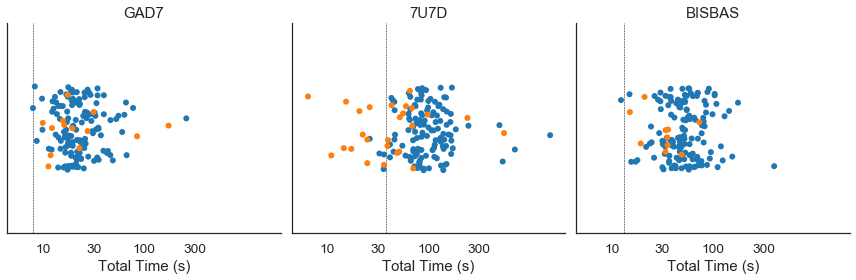

In [6]:
## Extract resposne times.
RT = surveys[['Subject','GAD7-RT','7U7D-RT','BISBAS-RT']].copy()

## Threshold items. 
reject = reject.merge(RT)
reject['GAD7-RT'] = np.where(reject['GAD7-RT'] < 8, 1, 0)
reject['7U7D-RT'] = np.where(reject['7U7D-RT'] < 37.5, 1, 0)
reject['BISBAS-RT'] = np.where(reject['BISBAS-RT'] < 13, 1, 0)
reject['Survey-RT'] = reject[['GAD7-RT','7U7D-RT','BISBAS-RT']].sum(axis=1)

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)

for ax, item, thresh in zip(axes, ['GAD7-Q08','7U7D-Q15','BISBAS-Q13'], [8, 37.5, 13]):
    
    ## Plot response times.
    col = item[:-4] + '-RT'
    sns.stripplot(np.log10(RT[col][reject[item]==0]), color='#1f77b4', size=6, ax=ax)
    sns.stripplot(np.log10(RT[col][reject[item]==1]), color='#ff7f0e', size=6, ax=ax)
    
    ## Add detail.
    ax.axvline(np.log10(thresh), lw=0.5, linestyle='--', color='k')
    ax.set(xticks=[1,1.5,2.0,2.5], xticklabels=['10','30','100','300'], xlabel='Total Time (s)',
           ylim=(-0.25,0.25), title=item[:-4])
    
sns.despine()
plt.tight_layout()

## Section 3: Behavior

In [7]:
## Load behavioral data.
data = read_csv(os.path.join('data','data.csv'))
data = data.query('Session==1').reset_index(drop=True)

#### 3.1 Accuracy

For 240 total trials, a one-sided Binomial test is significantly different than chance at 133 trials, or approximately 55% accuracy.

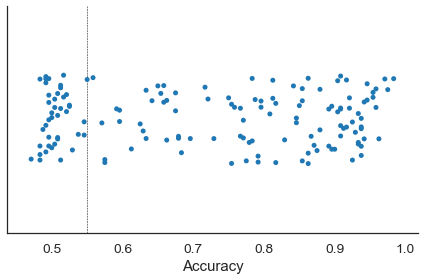

In [8]:
## Compute accuracy.
accuracy = data.groupby('Subject').Accuracy.mean().reset_index()
gw = data.query('Robot=="GW"').groupby('Subject').Accuracy.mean().reset_index()

## Threshold.
reject = reject.merge(accuracy)
reject['Accuracy'] = np.where(reject['Accuracy'] < 0.55, 1, 0)
reject['Accuracy'] = np.where(gw['Accuracy'] < 0.55, 1, reject['Accuracy'])

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot accuracy.
sns.stripplot(accuracy.Accuracy, ax=ax)

## Add detail.
ax.axvline(0.55, lw=0.5, linestyle='--', color='k')
ax.set(ylim=(-0.25,0.25))

sns.despine()
plt.tight_layout()

#### 3.2 Response Times

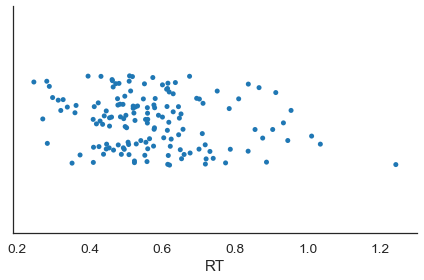

In [9]:
## Compute median response times.
rt = data.groupby('Subject').RT.median().reset_index()

## Threshold.
reject = reject.merge(rt)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,4))

## Plot accuracy.
sns.stripplot(rt.RT, ax=ax)

## Add detail.
ax.set(ylim=(-0.25,0.25))

sns.despine()
plt.tight_layout()

## Section 4: Apply Rejections

In [10]:
## Apply rejections.
reject['Reject'] = np.logical_or(reject['Accuracy'], reject['Infreq'] > 1).astype(int)

## Save.
reject.to_csv(os.path.join('data','reject.csv'), index=False)

## Print info.
reject.mean()

Comp-Loops    1.189189
GAD7-Q08      0.087838
7U7D-Q15      0.175676
BISBAS-Q13    0.067568
Infreq        0.331081
GAD7-RT       0.006757
7U7D-RT       0.101351
BISBAS-RT     0.006757
Survey-RT     0.114865
Accuracy      0.290541
RT            0.572277
Reject        0.304054
dtype: float64